In [1]:

# --- TensorFlow GPU Setup (must be first cell!) ---
import os
import tensorflow as tf

# Use only 1 GPU (optional)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Clear any pre-existing sessions
tf.keras.backend.clear_session()

# ✅ Enable memory growth BEFORE anything initializes the GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled.")
    except RuntimeError as e:
        print("❌ Failed to set GPU memory growth:", e)

# Optional: disable XLA JIT if facing cuDNN autotune issues
tf.config.optimizer.set_jit(False)

# Verify GPU availability
print("GPUs Available:", tf.config.list_physical_devices('GPU'))



✅ GPU memory growth enabled.
GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# --- Remaining Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import *


In [3]:
import os
import seaborn as sns

base_dir = "/kaggle/input"
categories = ["im_Dyskeratotic", "im_Koilocytotic", "im_Metaplastic", 
              "im_Parabasal", "im_Superficial-Intermediate"]

sns.set(style="whitegrid")

# Check image counts for all the classes in the dataset
image_counts = {}

for category in categories:
    category_path = os.path.join(base_dir, category, category, "CROPPED")
    image_counts[category] = len([f for f in os.listdir(category_path) if f.endswith('.bmp')])

print(image_counts)

{'im_Dyskeratotic': 813, 'im_Koilocytotic': 825, 'im_Metaplastic': 793, 'im_Parabasal': 787, 'im_Superficial-Intermediate': 831}


In [4]:
import glob
import shutil
from sklearn.model_selection import train_test_split

class DatasetDivision:
    def __init__(self, root_dir, output_dir):
        self.root_dir = root_dir
        self.output_dir = output_dir

    def divide_dataset(self):
        """Divides dataset into train, val, and test splits."""
        for class_dir in os.listdir(self.root_dir):
            cropped_path = os.path.join(self.root_dir, class_dir, class_dir, 'CROPPED')
            files = glob.glob(os.path.join(cropped_path, '*.bmp'))

            train_val, test = train_test_split(files, test_size=0.2, random_state=42)
            train, val = train_test_split(train_val, test_size=0.25, random_state=42)

            for split, split_files in zip(['train', 'val', 'test'], [train, val, test]):
                split_dir = os.path.join(self.output_dir, split, class_dir)
                os.makedirs(split_dir, exist_ok=True)
                for file in split_files:
                    shutil.copy(file, split_dir)

        print("Dataset division completed.")

In [5]:
def print_tree(directory, indent=0):
    for item in os.listdir(directory):
        path = os.path.join(directory, item)
        if os.path.isdir(path):
            print("  " * indent + "|-- " + item)
            print_tree(path, indent + 1)

print(f"Tree for: {base_dir}")
print_tree(base_dir)

Tree for: /kaggle/input
|-- im_Parabasal
  |-- im_Parabasal
    |-- CROPPED
|-- im_Dyskeratotic
  |-- im_Dyskeratotic
    |-- CROPPED
|-- im_Metaplastic
  |-- im_Metaplastic
    |-- CROPPED
|-- im_Superficial-Intermediate
  |-- im_Superficial-Intermediate
    |-- CROPPED
|-- im_Koilocytotic
  |-- im_Koilocytotic
    |-- CROPPED


In [6]:
path_dir = base_dir
output_dir = "/kaggle/working/sipakmedFormat"

# Initialize the class
datasetdiv1 = DatasetDivision(path_dir, output_dir)

# Call divide_dataset without additional arguments
datasetdiv1.divide_dataset()


Dataset division completed.


In [7]:
base_dir = "/kaggle/working/sipakmedFormat"
print(f"Tree for: {base_dir}")
print_tree(base_dir)

Tree for: /kaggle/working/sipakmedFormat
|-- val
  |-- im_Koilocytotic
  |-- im_Dyskeratotic
  |-- im_Parabasal
  |-- im_Superficial-Intermediate
  |-- im_Metaplastic
|-- test
  |-- im_Koilocytotic
  |-- im_Dyskeratotic
  |-- im_Parabasal
  |-- im_Superficial-Intermediate
  |-- im_Metaplastic
|-- train
  |-- im_Koilocytotic
  |-- im_Dyskeratotic
  |-- im_Parabasal
  |-- im_Superficial-Intermediate
  |-- im_Metaplastic


Path to images: /kaggle/working/sipakmedFormat
Number of classes: 5
Class names: ['im_Dyskeratotic', 'im_Koilocytotic', 'im_Metaplastic', 'im_Parabasal', 'im_Superficial-Intermediate']


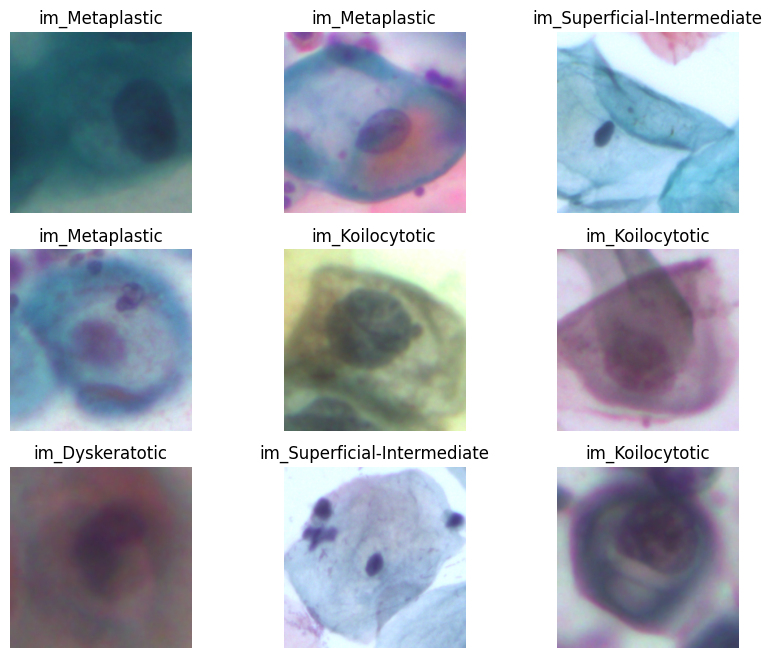

In [8]:
from fastai.vision.all import *
from fastai.vision.all import ImageDataLoaders, Resize, Normalize, imagenet_stats

# Set the batch size and path to your images
batch_size = 10
path_img = output_dir
print(f"Path to images: {path_img}")

# Load data from the directory using `ImageDataLoaders`
data = ImageDataLoaders.from_folder(path_img, train='train', valid='val',
                                    item_tfms=Resize(224), batch_tfms=Normalize.from_stats(*imagenet_stats),
                                    bs=batch_size)

# Visualize a batch of images
data.show_batch(nrows=3, figsize=(10,8))  # Correct argument is `nrows` instead of `rows`

# Print the number of classes and other dataset info
print(f"Number of classes: {len(data.vocab)}")
print(f"Class names: {data.vocab}")


In [9]:
import numpy as np
np.bool = bool
from imgaug import augmenters as iaa

In [10]:
import imgaug
print(imgaug.__file__)

/usr/local/lib/python3.10/dist-packages/imgaug/__init__.py


In [11]:
import os
import glob
import cv2
import numpy as np
from imgaug import augmenters as iaa


class DataAugmentation:
    def __init__(self, root_dir="", output_dir=""):
        self.root_dir = root_dir
        self.output_dir = output_dir
        print("Instance of the DataAugmentation class created")

    def augmentation_of_image(self, image_path, output_path):
        # Ensure the image can be read
        img = cv2.imread(image_path)
        if img is None:
            print(f"ERROR: Unable to read image {image_path}")
            return

        augmenters = [
            iaa.SomeOf(2, [
                iaa.Affine(rotate=(-90, 90)),
                iaa.Affine(scale={"x": (0.5, 0.9), "y": (0.5, 0.9)}),
                iaa.Affine(translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)}),
                iaa.Affine(shear=(-2, 2)),
                iaa.Fliplr(1.0),
                iaa.Flipud(1.0)
            ], random_order=True),
            iaa.SomeOf(2, [
                iaa.CLAHE(clip_limit=(1, 10)),
                iaa.GammaContrast((0.5, 2.0)),
                iaa.HistogramEqualization()
            ], random_order=True),
            iaa.OneOf([
                iaa.EdgeDetect(alpha=(0, 0.7)),
                iaa.DirectedEdgeDetect(alpha=(0, 0.7), direction=(0.0, 1.0))
            ]),
            iaa.OneOf([
                iaa.Canny(),
                iaa.Canny(alpha=(0.5, 1.0), sobel_kernel_size=[3, 7])
            ]),
            iaa.OneOf([
                iaa.ChannelShuffle(1.0),
                iaa.Grayscale(1.0),
                iaa.MultiplyHueAndSaturation((0.5, 1.5), per_channel=True),
                iaa.AddToHueAndSaturation((-50, 50), per_channel=True),
                iaa.KMeansColorQuantization(n_colors=(4, 16))
            ]),
            iaa.OneOf([
                iaa.AdditiveGaussianNoise(scale=0.111 * 255, per_channel=True),
                iaa.GaussianBlur(sigma=(0, 1.22)),
                iaa.AdditiveLaplaceNoise(scale=(0, 0.111 * 255))
            ])
        ]

        for idx, augmenter in enumerate(augmenters):
            augmented_images = augmenter(images=np.array([img], dtype=np.uint8))
            cv2.imwrite(os.path.join(output_path, f"{os.path.splitext(os.path.basename(image_path))[0]}_aug_{idx}.jpg"), augmented_images[0])


class DataAugmentationExtension:
    def __init__(self, directory=""):
        self.directory = directory

    def extend_dataset(self, directory):
        library_augment = DataAugmentation()
        self.directory = directory

        for folder in os.listdir(directory):
            class_path = os.path.join(directory, folder)
            if os.path.isdir(class_path):
                image_files = glob.glob(os.path.join(class_path, '*.bmp'))
                for image_file in image_files:
                    library_augment.augmentation_of_image(image_file, class_path)

if __name__ == "__main__":
    target_directory = "/kaggle/working/sipakmedFormat/train"
    dataset_extender = DataAugmentationExtension()
    dataset_extender.extend_dataset(target_directory)

Instance of the DataAugmentation class created


In [12]:
import os

def print_tree(dir_path, indent=""):
    print(f"{indent}- {os.path.basename(dir_path)}: {len([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])} files")
    for subdir in os.listdir(dir_path):
        subdir_path = os.path.join(dir_path, subdir)
        if os.path.isdir(subdir_path):
            print_tree(subdir_path, indent + "  ")

print_tree("/kaggle/working/sipakmedFormat")

- sipakmedFormat: 0 files
  - test: 0 files
    - im_Dyskeratotic: 163 files
    - im_Metaplastic: 159 files
    - im_Koilocytotic: 165 files
    - im_Superficial-Intermediate: 167 files
    - im_Parabasal: 158 files
  - train: 0 files
    - im_Dyskeratotic: 3409 files
    - im_Metaplastic: 3325 files
    - im_Koilocytotic: 3465 files
    - im_Superficial-Intermediate: 3486 files
    - im_Parabasal: 3297 files
  - val: 0 files
    - im_Dyskeratotic: 163 files
    - im_Metaplastic: 159 files
    - im_Koilocytotic: 165 files
    - im_Superficial-Intermediate: 166 files
    - im_Parabasal: 158 files


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to dataset
path = "/kaggle/working/sipakmedFormat/"

# Data Augmentation for Training
train_datagen = ImageDataGenerator(featurewise_center=False,
                                   rotation_range=5, fill_mode="nearest",
                                   zoom_range=[1/1.0, 1/1.0], width_shift_range=0.0, height_shift_range=0.0,
                                   horizontal_flip=True, vertical_flip=True,
                                   brightness_range=[0.5, 1.3], channel_shift_range=20)

# No Data Augmentation for Validation and Test
no_DA_IDG = ImageDataGenerator()

# Load training, validation, and test data
training_set = train_datagen.flow_from_directory(path + "train/",
                                                target_size=(224, 224),
                                                color_mode='rgb',
                                                batch_size=32,
                                                class_mode='categorical', shuffle=True)

validation_set = no_DA_IDG.flow_from_directory(path + "val/",
                                                target_size=(224, 224),
                                                color_mode='rgb',
                                                class_mode='categorical',
                                                shuffle=True)

test_set_V2 = no_DA_IDG.flow_from_directory(path + "test/",
                                            target_size=(224, 224),
                                            color_mode='rgb',
                                            batch_size=1,
                                            class_mode='categorical',
                                            shuffle=False)

Found 16982 images belonging to 5 classes.
Found 811 images belonging to 5 classes.
Found 812 images belonging to 5 classes.


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    cm = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    plt.figure(figsize=(12, 8))
    disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
    plt.xticks(rotation=45, fontsize=10, ha='right')
    plt.yticks(fontsize=10)
    plt.grid(False)
    plt.title('Confusion Matrix')
    plt.show()

def evaluate_model(history, true_labels, predicted_labels, class_names):
    plot_training_history(history)    
    plot_confusion_matrix(true_labels, predicted_labels, class_names)

true_classes = test_set_V2.classes
class_labels = list(test_set_V2.class_indices.keys())

In [14]:
pip install --upgrade tensorflow

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 76.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 68.8 MB/s eta 0:00:00:00:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.0
    Uninstalling tensorboard-2.17.0:
      Successfully uninstalled tensorboard-2.17.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.0
    Uninstalling tensorflow-2.17.0:
      Successfully uninstalled tensorflow-2.17.0
ERROR: 

In [18]:
exit()

## VGG-16

✅ GPU memory growth enabled.
Found 16982 images belonging to 5 classes.
Found 811 images belonging to 5 classes.
Found 812 images belonging to 5 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


530/530 ━━━━━━━━━━━━━━━━━━━━ 226s 415ms/step - accuracy: 0.4585 - loss: 1.7240 - val_accuracy: 0.8900 - val_loss: 0.3096
Epoch 2/10
  1/530 ━━━━━━━━━━━━━━━━━━━━ 1:29 169ms/step - accuracy: 0.6250 - loss: 1.0149

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 821us/step - accuracy: 0.6250 - loss: 1.0149 - val_accuracy: 0.8182 - val_loss: 0.4759
Epoch 3/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 229s 426ms/step - accuracy: 0.6979 - loss: 0.9423 - val_accuracy: 0.9050 - val_loss: 0.2643
Epoch 4/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 174us/step - accuracy: 0.7812 - loss: 0.8128 - val_accuracy: 1.0000 - val_loss: 0.0133
Epoch 5/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 220s 411ms/step - accuracy: 0.7615 - loss: 0.7113 - val_accuracy: 0.9350 - val_loss: 0.2092
Epoch 6/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 133us/step - accuracy: 0.6875 - loss: 0.6489 - val_accuracy: 1.0000 - val_loss: 0.0162
Epoch 7/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 227s 422ms/step - accuracy: 0.7846 - loss: 0.6357 - val_accuracy: 0.9250 - val_loss: 0.1980
812/812 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9203 - loss: 0.2441
✅ Test Accuracy: 92.12%
812/812 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step

🎯 Results for VGG-16:
Accuracy:       0.9212
Precision:      0.9220
Recall:         

<Figure size 800x600 with 0 Axes>

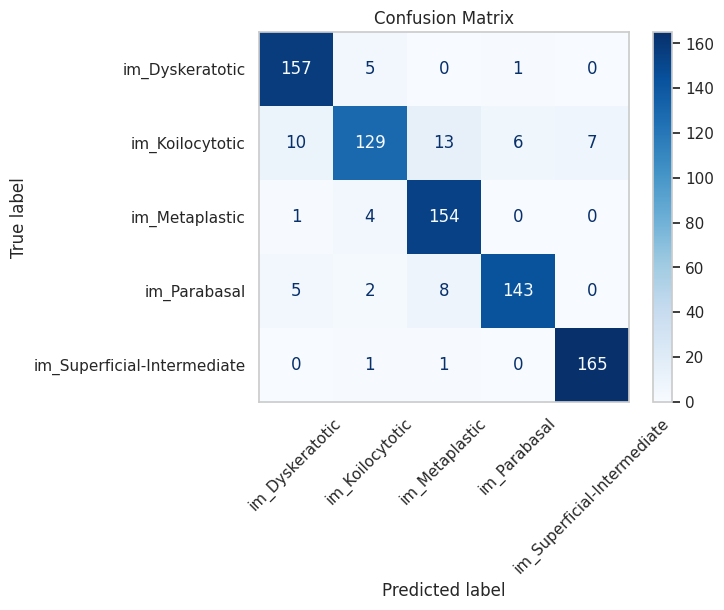

In [16]:
# --- TensorFlow GPU Setup ---
import os
import tensorflow as tf

# Use only 1 GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
tf.keras.backend.clear_session()

# Enable memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled.")
    except RuntimeError as e:
        print("❌ Failed to set GPU memory growth:", e)

# --- Required Libraries ---
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, Dropout, BatchNormalization, GlobalMaxPool2D
from keras.applications import VGG16
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, matthews_corrcoef, roc_auc_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize

# --- Define VGG-16 Model Function ---
def VGG_16(seed=None):
    np.random.seed(seed)
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers[:13]:
        layer.trainable = False
    for layer in base_model.layers[13:]:
        layer.trainable = True

    x = base_model.get_layer('block4_conv3').output
    x = GlobalMaxPool2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu', name='dense_1024')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(5, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# --- Paths and Data ---
path = "/kaggle/working/sipakmedFormat/"
batch_size = 32

train_gen = ImageDataGenerator(featurewise_center=False,
                               rotation_range=5,
                               zoom_range=0.0,
                               width_shift_range=0.0, height_shift_range=0.0,
                               horizontal_flip=True, vertical_flip=True,
                               brightness_range=[0.5, 1.3],
                               channel_shift_range=20)

val_test_gen = ImageDataGenerator()

training_set = train_gen.flow_from_directory(path + "train/", target_size=(224, 224),
                                             color_mode='rgb', batch_size=batch_size,
                                             class_mode='categorical', shuffle=True)

validation_set = val_test_gen.flow_from_directory(path + "val/", target_size=(224, 224),
                                                  color_mode='rgb', batch_size=batch_size,
                                                  class_mode='categorical', shuffle=True)

test_set_V2 = val_test_gen.flow_from_directory(path + "test/", target_size=(224, 224),
                                               color_mode='rgb', batch_size=1,
                                               class_mode='categorical', shuffle=False)

# --- Initialize and Train Model ---
model_vgg16 = VGG_16()
model_vgg16.compile(optimizer=Adam(learning_rate=1e-4),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model_vgg16.fit(
    training_set,
    steps_per_epoch=training_set.samples // training_set.batch_size,
    epochs=10,
    validation_data=validation_set,
    validation_steps=validation_set.samples // validation_set.batch_size,
    callbacks=[early_stopping]
)

# --- Evaluation ---
test_loss, test_acc = model_vgg16.evaluate(test_set_V2)
print(f"✅ Test Accuracy: {test_acc * 100:.2f}%")

# Predictions
predictions = model_vgg16.predict(test_set_V2, steps=test_set_V2.samples)
pred_classes = np.argmax(predictions, axis=1)
true_classes = test_set_V2.classes
class_labels = list(test_set_V2.class_indices.keys())

# Metrics
true_classes_bin = label_binarize(true_classes, classes=np.unique(true_classes))
acc = accuracy_score(true_classes, pred_classes)
prec = precision_score(true_classes, pred_classes, average='macro')
rec = recall_score(true_classes, pred_classes, average='macro')
f1 = f1_score(true_classes, pred_classes, average='macro')
mcc = matthews_corrcoef(true_classes, pred_classes)
try:
    auc = roc_auc_score(true_classes_bin, predictions, average='macro', multi_class='ovr')
except:
    auc = float('nan')

# --- Results ---
print("\n🎯 Results for VGG-16:")
print(f"Accuracy:       {acc:.4f}")
print(f"Precision:      {prec:.4f}")
print(f"Recall:         {rec:.4f}")
print(f"F1 Score:       {f1:.4f}")
print(f"MCC:            {mcc:.4f}")
print(f"AUC-ROC Score:  {auc:.4f}")

# --- Save metrics for plotting ---
acc_vgg16 = acc
prec_vgg16 = prec
rec_vgg16 = rec
f1_vgg16 = f1
mcc_vgg16 = mcc
auc_vgg16 = auc

print("\n📘 Classification Report:\n", classification_report(true_classes, pred_classes, target_names=class_labels))

# --- Confusion Matrix ---
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', values_format='d')
plt.xticks(rotation=45)
plt.grid(False)
plt.title("Confusion Matrix")
plt.show()

## VGG-19

Found 16982 images belonging to 5 classes.
Found 811 images belonging to 5 classes.
Found 812 images belonging to 5 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


530/530 ━━━━━━━━━━━━━━━━━━━━ 253s 464ms/step - accuracy: 0.5173 - loss: 1.4965 - val_accuracy: 0.8988 - val_loss: 0.2776
Epoch 2/10
  1/530 ━━━━━━━━━━━━━━━━━━━━ 1:46 201ms/step - accuracy: 0.7500 - loss: 0.5848

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 896us/step - accuracy: 0.7500 - loss: 0.5848 - val_accuracy: 1.0000 - val_loss: 0.0554
Epoch 3/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 239s 445ms/step - accuracy: 0.7416 - loss: 0.7618 - val_accuracy: 0.8438 - val_loss: 0.4846
Epoch 4/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 168us/step - accuracy: 0.8125 - loss: 0.7095 - val_accuracy: 0.9091 - val_loss: 0.2366
Epoch 5/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 246s 459ms/step - accuracy: 0.7791 - loss: 0.6533 - val_accuracy: 0.9125 - val_loss: 0.2339
812/812 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9088 - loss: 0.2672
✅ Test Accuracy: 90.89%
812/812 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step

🎯 Results for VGG-19:
Accuracy:       0.9089
Precision:      0.9087
Recall:         0.9091
F1 Score:       0.9079
MCC:            0.8866
AUC-ROC Score:  0.9893

📘 Classification Report:
                              precision    recall  f1-score   support

            im_Dyskeratotic       0.91      0.96      0.93       163
            im_Ko

<Figure size 800x600 with 0 Axes>

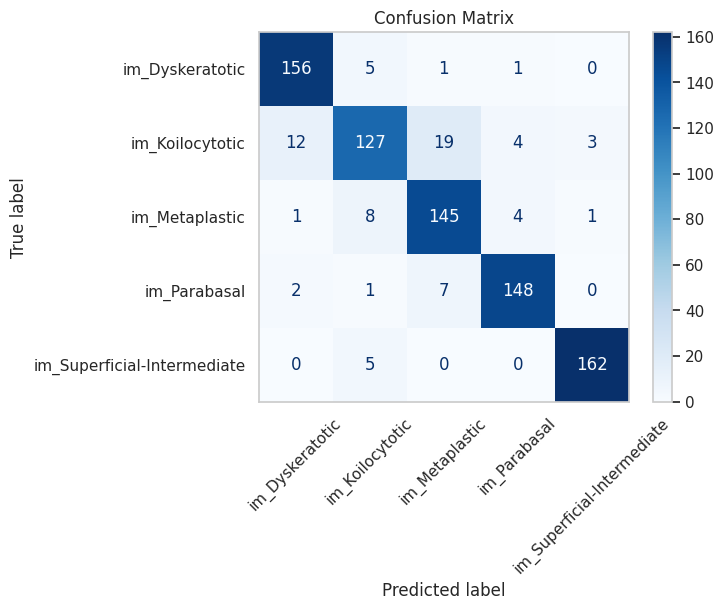

In [20]:
# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, Dropout, BatchNormalization, GlobalMaxPool2D
from keras.applications import VGG19
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, matthews_corrcoef, roc_auc_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize

# --- VGG-19 Model Function ---
def VGG_19(seed=None):
    np.random.seed(seed)
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers[:17]:
        layer.trainable = False
    for layer in base_model.layers[17:]:
        layer.trainable = True

    x = base_model.get_layer('block5_conv2').output
    x = GlobalMaxPool2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu', name='dense_1024')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(5, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# --- Paths and Data ---
path = "/kaggle/working/sipakmedFormat/"
batch_size = 32

train_gen = ImageDataGenerator(featurewise_center=False,
                               rotation_range=5,
                               zoom_range=0.0,
                               width_shift_range=0.0, height_shift_range=0.0,
                               horizontal_flip=True, vertical_flip=True,
                               brightness_range=[0.5, 1.3],
                               channel_shift_range=20)

val_test_gen = ImageDataGenerator()

training_set = train_gen.flow_from_directory(path + "train/", target_size=(224, 224),
                                             color_mode='rgb', batch_size=batch_size,
                                             class_mode='categorical', shuffle=True)

validation_set = val_test_gen.flow_from_directory(path + "val/", target_size=(224, 224),
                                                  color_mode='rgb', batch_size=batch_size,
                                                  class_mode='categorical', shuffle=True)

test_set_V2 = val_test_gen.flow_from_directory(path + "test/", target_size=(224, 224),
                                               color_mode='rgb', batch_size=1,
                                               class_mode='categorical', shuffle=False)

# --- Initialize and Train Model ---
model_vgg19 = VGG_19()
model_vgg19.compile(optimizer=Adam(learning_rate=1e-4),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model_vgg19.fit(
    training_set,
    steps_per_epoch=training_set.samples // training_set.batch_size,
    epochs=10,
    validation_data=validation_set,
    validation_steps=validation_set.samples // validation_set.batch_size,
    callbacks=[early_stopping]
)

# --- Evaluation ---
test_loss, test_acc = model_vgg19.evaluate(test_set_V2)
print(f"✅ Test Accuracy: {test_acc * 100:.2f}%")

# --- Predictions ---
predictions = model_vgg19.predict(test_set_V2, steps=test_set_V2.samples)
pred_classes = np.argmax(predictions, axis=1)
true_classes = test_set_V2.classes
class_labels = list(test_set_V2.class_indices.keys())

# --- Metrics ---
true_classes_bin = label_binarize(true_classes, classes=np.unique(true_classes))
acc = accuracy_score(true_classes, pred_classes)
prec = precision_score(true_classes, pred_classes, average='macro')
rec = recall_score(true_classes, pred_classes, average='macro')
f1 = f1_score(true_classes, pred_classes, average='macro')
mcc = matthews_corrcoef(true_classes, pred_classes)
try:
    auc = roc_auc_score(true_classes_bin, predictions, average='macro', multi_class='ovr')
except:
    auc = float('nan')

# --- Print Results ---
print("\n🎯 Results for VGG-19:")
print(f"Accuracy:       {acc:.4f}")
print(f"Precision:      {prec:.4f}")
print(f"Recall:         {rec:.4f}")
print(f"F1 Score:       {f1:.4f}")
print(f"MCC:            {mcc:.4f}")
print(f"AUC-ROC Score:  {auc:.4f}")

print("\n📘 Classification Report:\n", classification_report(true_classes, pred_classes, target_names=class_labels))

# --- Confusion Matrix ---
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', values_format='d')
plt.xticks(rotation=45)
plt.grid(False)
plt.title("Confusion Matrix")
plt.show()

# --- Save Metrics for Plotting Later ---
acc_vgg19 = acc
prec_vgg19 = prec
rec_vgg19 = rec
f1_vgg19 = f1
mcc_vgg19 = mcc
auc_vgg19 = auc


## ResNet50

Found 16982 images belonging to 5 classes.
Found 811 images belonging to 5 classes.
Found 812 images belonging to 5 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


530/530 ━━━━━━━━━━━━━━━━━━━━ 276s 467ms/step - accuracy: 0.6379 - loss: 1.1766 - val_accuracy: 0.9162 - val_loss: 0.2542
Epoch 2/10
  1/530 ━━━━━━━━━━━━━━━━━━━━ 1:10 133ms/step - accuracy: 0.8125 - loss: 0.5766

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


530/530 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8125 - loss: 0.5766 - val_accuracy: 0.7273 - val_loss: 0.6448
Epoch 3/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 230s 428ms/step - accuracy: 0.8350 - loss: 0.5086 - val_accuracy: 0.9375 - val_loss: 0.1894
Epoch 4/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 102us/step - accuracy: 0.8750 - loss: 0.3780 - val_accuracy: 0.8182 - val_loss: 0.4952
Epoch 5/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 229s 427ms/step - accuracy: 0.8754 - loss: 0.3777 - val_accuracy: 0.9388 - val_loss: 0.1743
Epoch 6/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 129us/step - accuracy: 0.8125 - loss: 0.6035 - val_accuracy: 0.7273 - val_loss: 0.6931
Epoch 7/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 236s 440ms/step - accuracy: 0.8928 - loss: 0.3120 - val_accuracy: 0.9425 - val_loss: 0.1587
Epoch 8/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - accuracy: 0.9375 - loss: 0.1061 - val_accuracy: 1.0000 - val_loss: 0.0597
Epoch 9/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 243s 452ms/step - accuracy: 0.9070 - loss: 0.2757 - val_a

<Figure size 800x600 with 0 Axes>

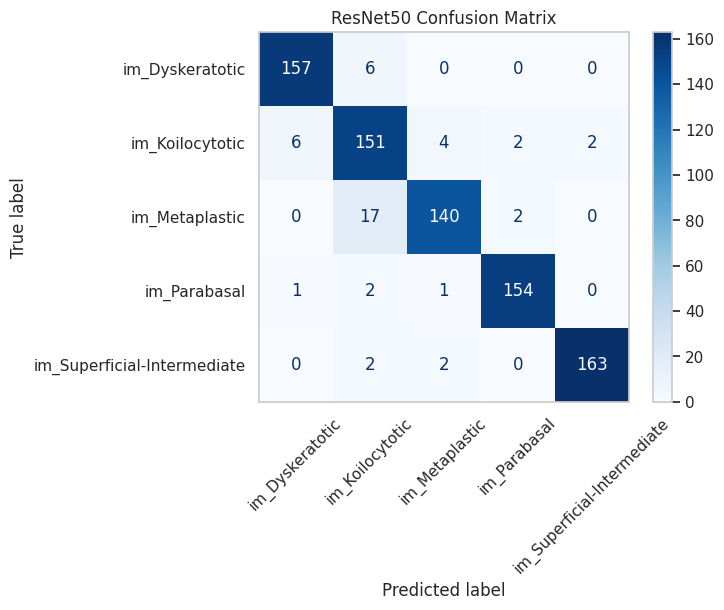

In [21]:
# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalMaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize

# --- ResNet50 Model Function ---
def ResNet_50(seed=None):
    np.random.seed(seed)
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers[:143]:
        layer.trainable = False
    for layer in base_model.layers[143:]:
        layer.trainable = True

    x = base_model.output
    x = GlobalMaxPool2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu', name="dense_1024")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(5, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model

# --- Paths & Data ---
path = "/kaggle/working/sipakmedFormat/"
batch_size = 32

train_gen = ImageDataGenerator(
    featurewise_center=False,
    rotation_range=5,
    fill_mode="nearest",
    zoom_range=[1.0, 1.0],
    width_shift_range=0.0,
    height_shift_range=0.0,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.3],
    channel_shift_range=20
)

val_test_gen = ImageDataGenerator()

training_set = train_gen.flow_from_directory(path + "train/", target_size=(224, 224),
                                             color_mode='rgb', batch_size=batch_size,
                                             class_mode='categorical', shuffle=True)

validation_set = val_test_gen.flow_from_directory(path + "val/", target_size=(224, 224),
                                                  color_mode='rgb', batch_size=batch_size,
                                                  class_mode='categorical', shuffle=True)

test_set_V2 = val_test_gen.flow_from_directory(path + "test/", target_size=(224, 224),
                                               color_mode='rgb', batch_size=1,
                                               class_mode='categorical', shuffle=False)

# --- Compile & Train ---
model_resnet50 = ResNet_50()
model_resnet50.compile(optimizer=Adam(learning_rate=1e-4),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_resnet = model_resnet50.fit(
    training_set,
    steps_per_epoch=training_set.samples // training_set.batch_size,
    epochs=10,
    validation_data=validation_set,
    validation_steps=validation_set.samples // validation_set.batch_size,
    callbacks=[early_stopping]
)

# --- Evaluate ---
test_loss, test_acc = model_resnet50.evaluate(test_set_V2)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# --- Predictions ---
predictions_resnet50 = model_resnet50.predict(test_set_V2, steps=test_set_V2.samples)
predicted_classes_resnet50 = np.argmax(predictions_resnet50, axis=1)
true_classes_resnet50 = test_set_V2.classes
class_labels = list(test_set_V2.class_indices.keys())

# --- Metrics ---
true_bin = label_binarize(true_classes_resnet50, classes=np.unique(true_classes_resnet50))

acc_resnet50 = accuracy_score(true_classes_resnet50, predicted_classes_resnet50)
prec_resnet50 = precision_score(true_classes_resnet50, predicted_classes_resnet50, average='macro')
rec_resnet50 = recall_score(true_classes_resnet50, predicted_classes_resnet50, average='macro')
f1_resnet50 = f1_score(true_classes_resnet50, predicted_classes_resnet50, average='macro')
mcc_resnet50 = matthews_corrcoef(true_classes_resnet50, predicted_classes_resnet50)

try:
    auc_resnet50 = roc_auc_score(true_bin, predictions_resnet50, average='macro', multi_class='ovr')
except:
    auc_resnet50 = float('nan')

# --- Print Results ---
print("\n Results for ResNet50:")
print(f"Accuracy:       {acc_resnet50:.4f}")
print(f"Precision:      {prec_resnet50:.4f}")
print(f"Recall:         {rec_resnet50:.4f}")
print(f"F1 Score:       {f1_resnet50:.4f}")
print(f"MCC:            {mcc_resnet50:.4f}")
print(f"AUC-ROC Score:  {auc_resnet50:.4f}")

print("\n Classification Report:\n", classification_report(true_classes_resnet50, predicted_classes_resnet50, target_names=class_labels))

# --- Confusion Matrix ---
cm = confusion_matrix(true_classes_resnet50, predicted_classes_resnet50)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', values_format='d')
plt.xticks(rotation=45)
plt.grid(False)
plt.title("ResNet50 Confusion Matrix")
plt.show()


## XceptionNet

Found 16982 images belonging to 5 classes.
Found 811 images belonging to 5 classes.
Found 812 images belonging to 5 classes.
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


530/530 ━━━━━━━━━━━━━━━━━━━━ 296s 489ms/step - accuracy: 0.3749 - loss: 2.0602 - val_accuracy: 0.7000 - val_loss: 0.8025
Epoch 2/10
  1/530 ━━━━━━━━━━━━━━━━━━━━ 1:57 221ms/step - accuracy: 0.4688 - loss: 1.4533

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


530/530 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.4688 - loss: 1.4533 - val_accuracy: 0.8182 - val_loss: 0.7680
Epoch 3/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 262s 488ms/step - accuracy: 0.5056 - loss: 1.5216 - val_accuracy: 0.7675 - val_loss: 0.6293
Epoch 4/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - accuracy: 0.4062 - loss: 1.6143 - val_accuracy: 0.9091 - val_loss: 0.4400
Epoch 5/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 245s 457ms/step - accuracy: 0.5504 - loss: 1.3553 - val_accuracy: 0.7788 - val_loss: 0.6292
Epoch 6/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 138us/step - accuracy: 0.4062 - loss: 1.5474 - val_accuracy: 0.7273 - val_loss: 0.5736
Epoch 7/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 247s 461ms/step - accuracy: 0.5701 - loss: 1.2722 - val_accuracy: 0.7287 - val_loss: 0.7819
812/812 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8536 - loss: 0.4122
✅ Test Accuracy: 78.20%
812/812 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step

📊 Results for XceptionNet
Accuracy:       0.7820
Precision:      0.7928
Recall:      

<Figure size 800x600 with 0 Axes>

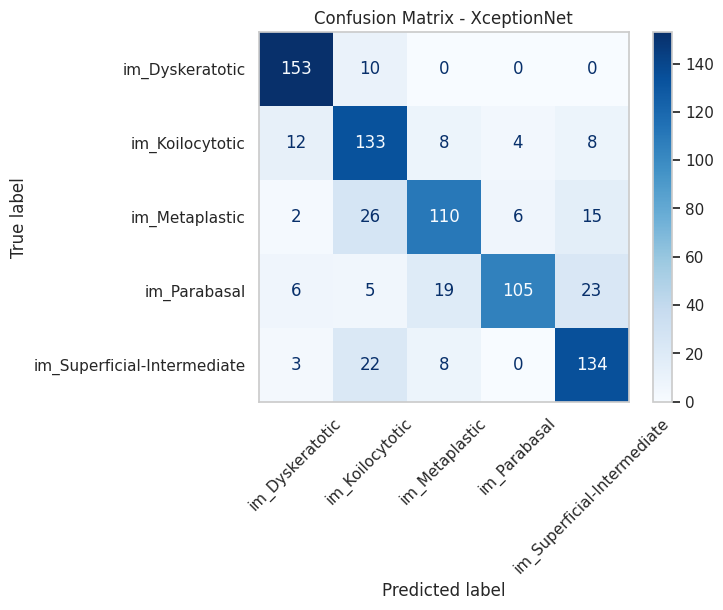

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, Dropout, BatchNormalization, GlobalMaxPool2D
from keras.applications import Xception
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, matthews_corrcoef, roc_auc_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize

# --- Define Xception Model ---
def XceptionNet(seed=None):
    np.random.seed(seed)
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers[:100]:
        layer.trainable = False
    for layer in base_model.layers[100:]:
        layer.trainable = True

    x = base_model.output
    x = GlobalMaxPool2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu', name='dense_1024')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(5, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

# --- Paths and Data ---
path = "/kaggle/working/sipakmedFormat/"
batch_size = 32

train_gen = ImageDataGenerator(
    featurewise_center=False,
    rotation_range=5,
    zoom_range=0.0,
    width_shift_range=0.0, height_shift_range=0.0,
    horizontal_flip=True, vertical_flip=True,
    brightness_range=[0.5, 1.3],
    channel_shift_range=20
)

val_test_gen = ImageDataGenerator()

training_set = train_gen.flow_from_directory(path + "train/", target_size=(224, 224),
                                             color_mode='rgb', batch_size=batch_size,
                                             class_mode='categorical', shuffle=True)

validation_set = val_test_gen.flow_from_directory(path + "val/", target_size=(224, 224),
                                                  color_mode='rgb', batch_size=batch_size,
                                                  class_mode='categorical', shuffle=True)

test_set_V2 = val_test_gen.flow_from_directory(path + "test/", target_size=(224, 224),
                                               color_mode='rgb', batch_size=1,
                                               class_mode='categorical', shuffle=False)

# --- Compile and Train ---
model_xception = XceptionNet()
model_xception.compile(optimizer=Adam(learning_rate=1e-4),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model_xception.fit(
    training_set,
    steps_per_epoch=training_set.samples // training_set.batch_size,
    epochs=10,
    validation_data=validation_set,
    validation_steps=validation_set.samples // validation_set.batch_size,
    callbacks=[early_stopping]
)

# --- Evaluate ---
test_loss, test_acc = model_xception.evaluate(test_set_V2)
print(f" Test Accuracy: {test_acc * 100:.2f}%")

# --- Predict ---
predictions_xception = model_xception.predict(test_set_V2, steps=test_set_V2.samples)
predicted_classes_xception = np.argmax(predictions_xception, axis=1)
true_classes_xception = test_set_V2.classes
class_labels = list(test_set_V2.class_indices.keys())

# --- Metrics ---
true_bin = label_binarize(true_classes_xception, classes=np.unique(true_classes_xception))
acc_xception = accuracy_score(true_classes_xception, predicted_classes_xception)
prec_xception = precision_score(true_classes_xception, predicted_classes_xception, average='macro')
rec_xception = recall_score(true_classes_xception, predicted_classes_xception, average='macro')
f1_xception = f1_score(true_classes_xception, predicted_classes_xception, average='macro')
mcc_xception = matthews_corrcoef(true_classes_xception, predicted_classes_xception)

try:
    auc_xception = roc_auc_score(true_bin, predictions_xception, average='macro', multi_class='ovr')
except:
    auc_xception = float('nan')

# --- Results ---
print("\n📊 Results for XceptionNet")
print(f"Accuracy:       {acc_xception:.4f}")
print(f"Precision:      {prec_xception:.4f}")
print(f"Recall:         {rec_xception:.4f}")
print(f"F1 Score:       {f1_xception:.4f}")
print(f"MCC:            {mcc_xception:.4f}")
print(f"AUC-ROC Score:  {auc_xception:.4f}")
print("\nClassification Report:\n", classification_report(true_classes_xception, predicted_classes_xception, target_names=class_labels))

# --- Confusion Matrix ---
cm = confusion_matrix(true_classes_xception, predicted_classes_xception)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', values_format='d')
plt.xticks(rotation=45)
plt.grid(False)
plt.title("Confusion Matrix - XceptionNet")
plt.show()


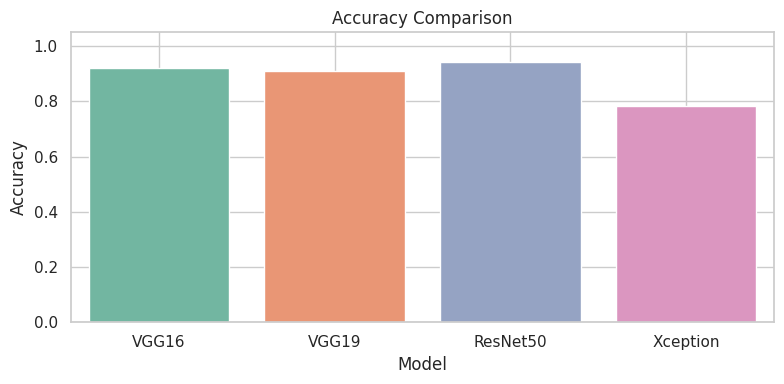

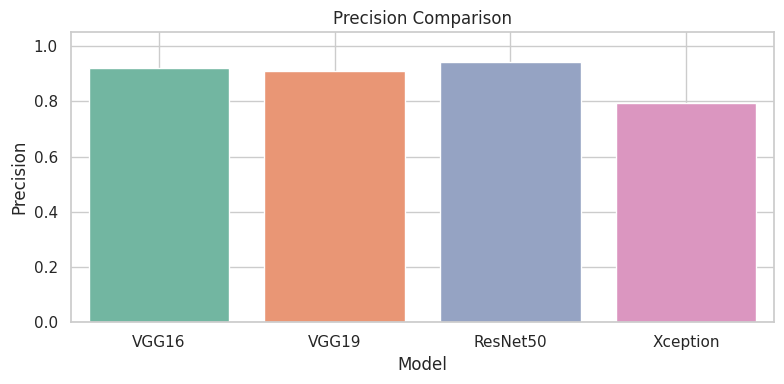

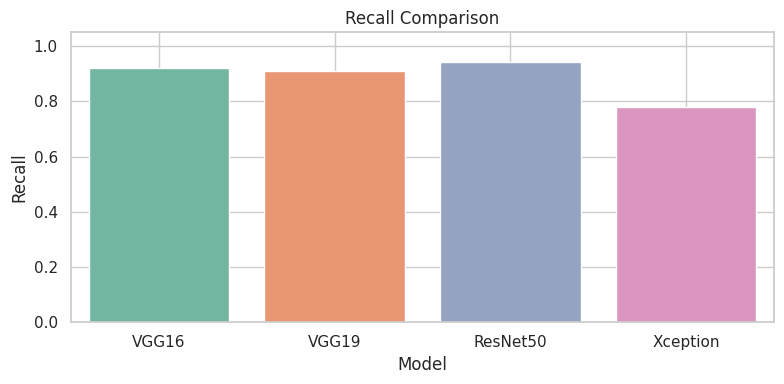

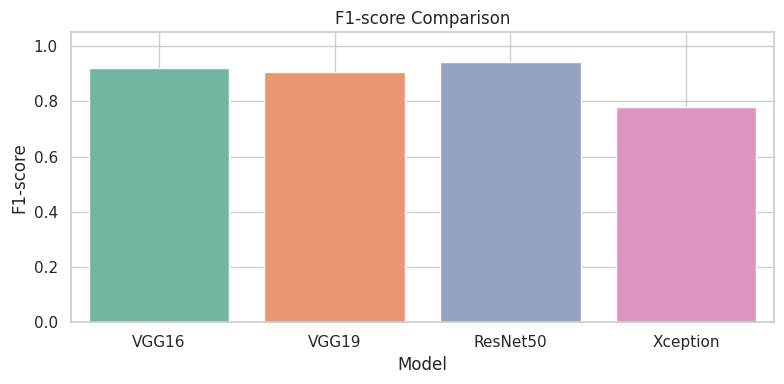

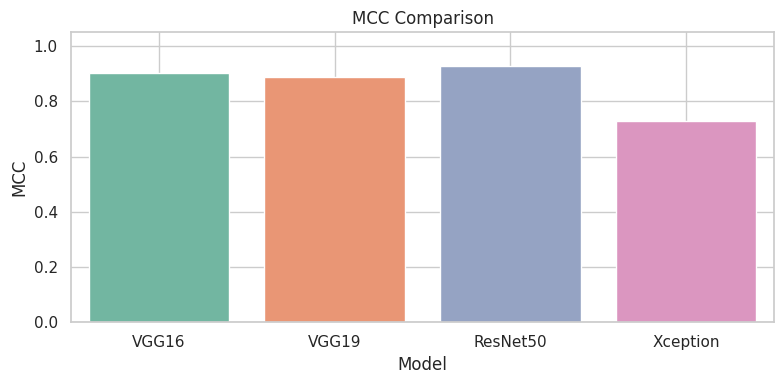

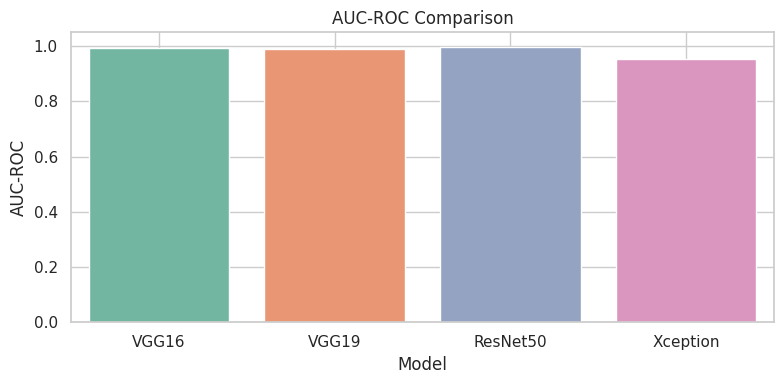

✅ Results saved to ml_model_scores.csv


In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt  # Make sure this is imported

# Combine metrics into a table
model_scores = [
    {"Model": "VGG16", "Accuracy": acc_vgg16, "Precision": prec_vgg16, "Recall": rec_vgg16, "F1-score": f1_vgg16, "MCC": mcc_vgg16, "AUC-ROC": auc_vgg16},
    {"Model": "VGG19", "Accuracy": acc_vgg19, "Precision": prec_vgg19, "Recall": rec_vgg19, "F1-score": f1_vgg19, "MCC": mcc_vgg19, "AUC-ROC": auc_vgg19},
    {"Model": "ResNet50", "Accuracy": acc_resnet50, "Precision": prec_resnet50, "Recall": rec_resnet50, "F1-score": f1_resnet50, "MCC": mcc_resnet50, "AUC-ROC": auc_resnet50},
    {"Model": "Xception", "Accuracy": acc_xception, "Precision": prec_xception, "Recall": rec_xception, "F1-score": f1_xception, "MCC": mcc_xception, "AUC-ROC": auc_xception}
]

df_scores = pd.DataFrame(model_scores)

# Plot each metric with smaller figure size
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'MCC', 'AUC-ROC']
for metric in metrics:
    plt.figure(figsize=(8, 4))  # smaller than (10, 5)
    sns.barplot(x='Model', y=metric, data=df_scores, palette='Set2')
    plt.title(f'{metric} Comparison')
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Save results
df_scores.to_csv("ml_model_scores.csv", index=False)
print("✅ Results saved to ml_model_scores.csv")



# Deep Hybrid Feature Fusion

In [31]:
train_datagen = ImageDataGenerator(featurewise_center=False,
                                   rotation_range = 5, fill_mode="nearest",
                                   zoom_range=[1/1.0, 1/1.0], width_shift_range=0.0, height_shift_range=0.0, # occasionally out of range
                                   horizontal_flip = True, vertical_flip=True,
                                   brightness_range=[0.5, 1.3], channel_shift_range=20)

no_DA_IDG = ImageDataGenerator()

# in training set: use data augmentation image data generator, for validation and test: no data augmentation.
training_set = train_datagen.flow_from_directory(path+"train/",
                                                target_size=(224, 224), # typical imagenet dimensions
                                                color_mode='rgb',
                                                batch_size=32,
                                                class_mode='categorical', shuffle=True)

training_set_V2 =  no_DA_IDG.flow_from_directory(path+"train/", ### TO USE FOR FEATURE EXTRACTION
                                                target_size=(224, 224), # typical imagenet dimensions
                                                color_mode='rgb',
                                                batch_size=1,
                                                class_mode='categorical', shuffle=False)

validation_set = no_DA_IDG.flow_from_directory(path+"val/",
                                                target_size=(224, 224),
                                                color_mode='rgb',
                                                class_mode='categorical',
                                                shuffle=True)

validation_set_V2 = no_DA_IDG.flow_from_directory(path+"val/",
                                                target_size=(224, 224),
                                                color_mode='rgb',
                                                batch_size=1,
                                                class_mode='categorical',
                                                shuffle=False)

test_set_V2 = no_DA_IDG.flow_from_directory(path+"test/",
                                                target_size=(224, 224),
                                                color_mode='rgb',
                                                batch_size=1,
                                                class_mode='categorical',
                                                shuffle=False)

Found 16982 images belonging to 5 classes.
Found 16982 images belonging to 5 classes.
Found 811 images belonging to 5 classes.
Found 811 images belonging to 5 classes.
Found 812 images belonging to 5 classes.


## Concatenation

In [32]:
from keras.utils import to_categorical
from keras.models import Model

# Use correct model variable names
vgg_extractor = Model(inputs=model_vgg16.input, outputs=model_vgg16.get_layer("dense_1024").output)
xcep_extractor = Model(inputs=model_xception.input, outputs=model_xception.get_layer("dense_1024").output)
vgg19_extractor = Model(inputs=model_vgg19.input, outputs=model_vgg19.get_layer("dense_1024").output)
r50_extractor = Model(inputs=model_resnet50.input, outputs=model_resnet50.get_layer("dense_1024").output)  # ✅ FIXED

# One-hot encode labels
y_train = to_categorical(training_set_V2.classes)
y_val = to_categorical(validation_set_V2.classes)
y_test = to_categorical(test_set_V2.classes)

# Feature extraction for training
X_train_m1 = vgg_extractor.predict(training_set_V2, steps=training_set_V2.samples)
X_train_m2 = xcep_extractor.predict(training_set_V2, steps=training_set_V2.samples)
X_train_m3 = vgg19_extractor.predict(training_set_V2, steps=training_set_V2.samples)
X_train_m4 = r50_extractor.predict(training_set_V2, steps=training_set_V2.samples)
X_train = np.concatenate([X_train_m1, X_train_m2, X_train_m3, X_train_m4], axis=1)

# Feature extraction for validation
X_val_m1 = vgg_extractor.predict(validation_set_V2, steps=validation_set_V2.samples)
X_val_m2 = xcep_extractor.predict(validation_set_V2, steps=validation_set_V2.samples)
X_val_m3 = vgg19_extractor.predict(validation_set_V2, steps=validation_set_V2.samples)
X_val_m4 = r50_extractor.predict(validation_set_V2, steps=validation_set_V2.samples)
X_val = np.concatenate([X_val_m1, X_val_m2, X_val_m3, X_val_m4], axis=1)

# Feature extraction for test
X_test_m1 = vgg_extractor.predict(test_set_V2, steps=test_set_V2.samples)
X_test_m2 = xcep_extractor.predict(test_set_V2, steps=test_set_V2.samples)
X_test_m3 = vgg19_extractor.predict(test_set_V2, steps=test_set_V2.samples)
X_test_m4 = r50_extractor.predict(test_set_V2, steps=test_set_V2.samples)
X_test = np.concatenate([X_test_m1, X_test_m2, X_test_m3, X_test_m4], axis=1)



/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16982/16982 ━━━━━━━━━━━━━━━━━━━━ 125s 7ms/step
16982/16982 ━━━━━━━━━━━━━━━━━━━━ 110s 6ms/step
16982/16982 ━━━━━━━━━━━━━━━━━━━━ 173s 10ms/step
16982/16982 ━━━━━━━━━━━━━━━━━━━━ 127s 7ms/step
811/811 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step
811/811 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
811/811 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step
811/811 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step
812/812 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step
812/812 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
812/812 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step
812/812 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step


## Train and Test

/usr/local/lib/python3.10/dist-packages/keras/src/layers/regularization/dropout.py:42: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1062/1062 - 6s - 5ms/step - acc: 0.8858 - loss: 0.3473 - val_acc: 0.9408 - val_loss: 0.1840
Epoch 2/20
1062/1062 - 2s - 2ms/step - acc: 0.9063 - loss: 0.3210 - val_acc: 0.9519 - val_loss: 0.1542
Epoch 3/20
1062/1062 - 2s - 2ms/step - acc: 0.9137 - loss: 0.3083 - val_acc: 0.9544 - val_loss: 0.1900
Epoch 4/20
1062/1062 - 2s - 2ms/step - acc: 0.9166 - loss: 0.3095 - val_acc: 0.9457 - val_loss: 0.2165
Epoch 5/20
1062/1062 - 2s - 2ms/step - acc: 0.9190 - loss: 0.3049 - val_acc: 0.9494 - val_loss: 0.2291
Epoch 6/20
1062/1062 - 2s - 2ms/step - acc: 0.9183 - loss: 0.3143 - val_acc: 0.9544 - val_loss: 0.2421
Epoch 7/20
1062/1062 - 2s - 2ms/step - acc: 0.9236 - loss: 0.3071 - val_acc: 0.9482 - val_loss: 0.2011
Epoch 8/20
1062/1062 - 2s - 2ms/step - acc: 0.9229 - loss: 0.3034 - val_acc: 0.9507 - val_loss: 0.2461
Epoch 9/20
1062/1062 - 2s - 2ms/step - acc: 0.9248 - loss: 0.3120 - val_acc: 0.9334 - val_loss: 0.2847
Epoch 10/20
1062/1062 - 2s - 2ms/step - acc: 0.9209 - loss: 0.3159 - val_

<Figure size 800x600 with 0 Axes>

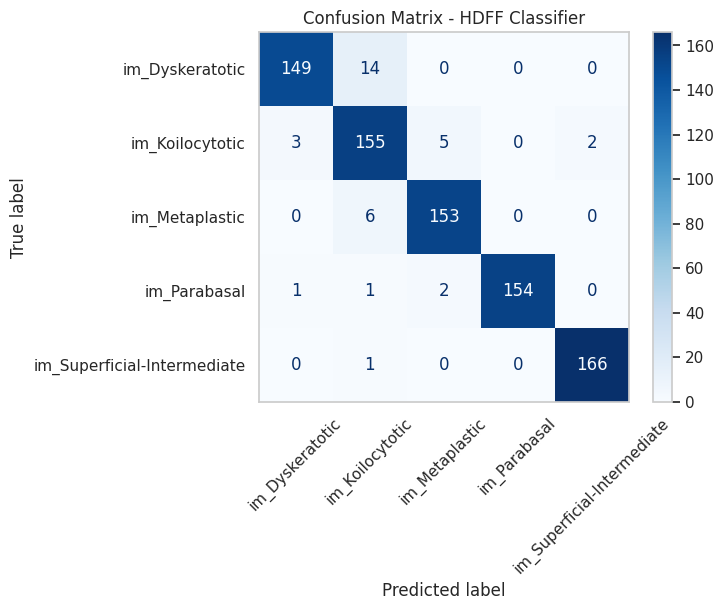

In [33]:

#  Imports and Setup 

import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dropout, BatchNormalization, Dense
from keras.optimizers import Adam
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, matthews_corrcoef,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize

# Ensure class_labels is defined correctly from test_set_V2
class_labels = list(test_set_V2.class_indices.keys())

# Set random seed
np.random.seed(668)

# Define HDFF Classifier 
model = Sequential()
model.add(Dropout(0.5, input_shape=(4096,)))  # Feature vector size: 1024 * 4
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))  # 5 classes

model_hdff = model
model_hdff.compile(optimizer=Adam(learning_rate=1e-3),
                   loss='categorical_crossentropy',
                   metrics=['acc'])

#  Train the Model   
epochs = 20
history_hdff = model_hdff.fit(
    X_train, y_train,
    batch_size=16,
    epochs=epochs,
    verbose=2,
    shuffle=True,
    validation_data=(X_val, y_val)
)

# Test the Model     
# Convert one-hot y_test to label indices
y_test_labels = np.argmax(y_test, axis=1)

# Predict class probabilities and predicted class labels
pred_prob = model_hdff.predict(X_test)
pred_labels = np.argmax(pred_prob, axis=1)

# Print base metrics
print("Accuracy Score:", accuracy_score(y_test_labels, pred_labels))
print("Confusion Matrix:\n", confusion_matrix(y_test_labels, pred_labels))

# Additional Metrics Block 
# Convert test labels to one-hot binary for AUC
y_test_bin = label_binarize(y_test_labels, classes=np.unique(y_test_labels))

# Compute all evaluation metrics
acc = accuracy_score(y_test_labels, pred_labels)
prec = precision_score(y_test_labels, pred_labels, average='macro')
rec = recall_score(y_test_labels, pred_labels, average='macro')
f1 = f1_score(y_test_labels, pred_labels, average='macro')
mcc = matthews_corrcoef(y_test_labels, pred_labels)

try:
    auc = roc_auc_score(y_test_bin, pred_prob, average='macro', multi_class='ovr')
except:
    auc = float('nan')

# Print full evaluation summary
print("\nResults for HDF Fusion Neural Model")
print(f"Accuracy:       {acc:.4f}")
print(f"Precision:      {prec:.4f}")
print(f"Recall:         {rec:.4f}")
print(f"F1 Score:       {f1:.4f}")
print(f"MCC:            {mcc:.4f}")
print(f"AUC-ROC Score:  {auc:.4f}")

# Classification report
print("\nClassification Report:\n", classification_report(y_test_labels, pred_labels, target_names=class_labels))

# --- Plot Confusion Matrix ---
cm = confusion_matrix(y_test_labels, pred_labels)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', values_format='d')
plt.xticks(rotation=45)
plt.grid(False)
plt.title("Confusion Matrix - HDFF Classifier")
plt.show()


In [34]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [35]:
# Convert one-hot labels to integer labels if needed
def to_labels(y):
    return np.argmax(y, axis=1) if len(y.shape) > 1 else y

y_train_lbl = to_labels(y_train)
y_val_lbl = to_labels(y_val)
y_test_lbl = to_labels(y_test)

# Merge training and validation
X_train_full = np.concatenate([X_train, X_val], axis=0)
y_train_full = np.concatenate([y_train_lbl, y_val_lbl], axis=0)


In [36]:
model_scores = []

def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    mcc = matthews_corrcoef(y_test, y_pred)

    try:
        y_bin = label_binarize(y_test, classes=np.unique(y_test))
        y_proba = model.predict_proba(X_test)
        auc = roc_auc_score(y_bin, y_proba, average='macro', multi_class='ovr')
    except:
        auc = float('nan')

    print(f"\n📊 {name}")
    print(f"Accuracy:       {acc:.4f}")
    print(f"Precision:      {prec:.4f}")
    print(f"Recall:         {rec:.4f}")
    print(f"F1-score:       {f1:.4f}")
    print(f"MCC:            {mcc:.4f}")
    print(f"AUC-ROC:        {auc:.4f}")
    print(classification_report(y_test, y_pred))

    # Save for comparison plot
    model_scores.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1,
        'MCC': mcc,
        'AUC-ROC': auc
    })

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_set_V2.class_indices.keys(), yticklabels=test_set_V2.class_indices.keys())
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()



📊 K-Nearest Neighbors
Accuracy:       0.9446
Precision:      0.9446
Recall:         0.9449
F1-score:       0.9444
MCC:            0.9309
AUC-ROC:        0.9917
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       163
           1       0.91      0.85      0.88       165
           2       0.90      0.95      0.93       159
           3       0.98      0.98      0.98       158
           4       0.98      0.97      0.98       167

    accuracy                           0.94       812
   macro avg       0.94      0.94      0.94       812
weighted avg       0.94      0.94      0.94       812



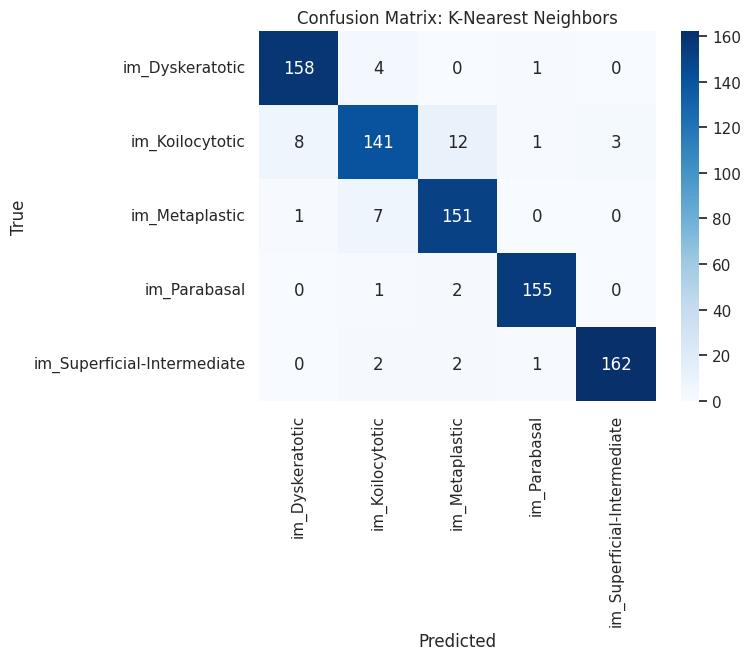


📊 Decision Tree
Accuracy:       0.9015
Precision:      0.9013
Recall:         0.9013
F1-score:       0.9008
MCC:            0.8770
AUC-ROC:        0.9383
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       163
           1       0.86      0.83      0.84       165
           2       0.90      0.84      0.87       159
           3       0.94      0.94      0.94       158
           4       0.92      0.98      0.94       167

    accuracy                           0.90       812
   macro avg       0.90      0.90      0.90       812
weighted avg       0.90      0.90      0.90       812



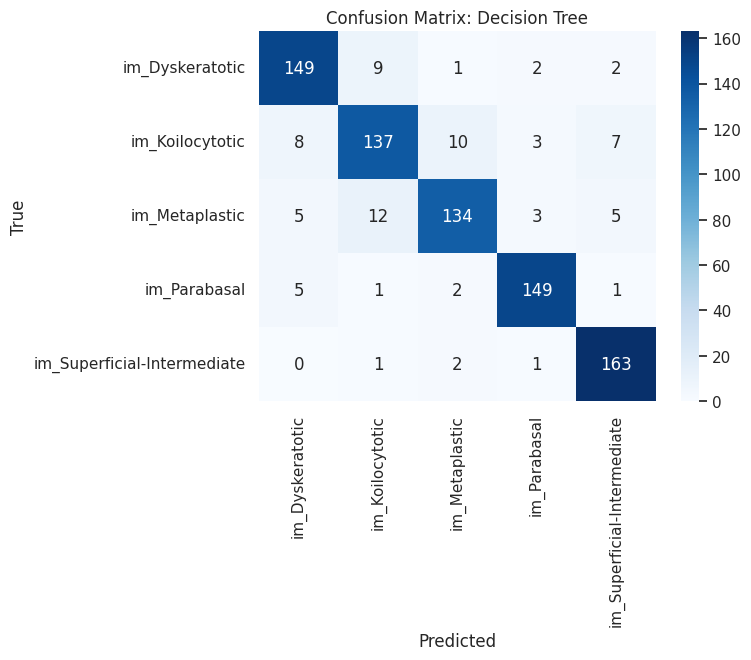


📊 Random Forest
Accuracy:       0.9532
Precision:      0.9536
Recall:         0.9533
F1-score:       0.9534
MCC:            0.9415
AUC-ROC:        0.9962
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       163
           1       0.90      0.90      0.90       165
           2       0.93      0.95      0.94       159
           3       0.99      0.97      0.98       158
           4       0.99      0.98      0.98       167

    accuracy                           0.95       812
   macro avg       0.95      0.95      0.95       812
weighted avg       0.95      0.95      0.95       812



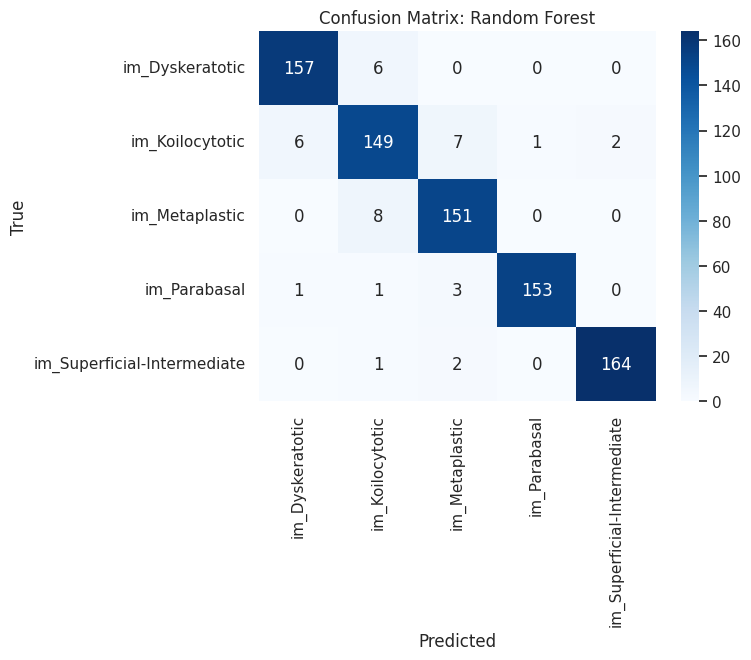


📊 SVM
Accuracy:       0.9643
Precision:      0.9647
Recall:         0.9643
F1-score:       0.9644
MCC:            0.9554
AUC-ROC:        0.9967
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       163
           1       0.93      0.93      0.93       165
           2       0.93      0.96      0.95       159
           3       1.00      0.97      0.99       158
           4       0.99      0.98      0.99       167

    accuracy                           0.96       812
   macro avg       0.96      0.96      0.96       812
weighted avg       0.96      0.96      0.96       812



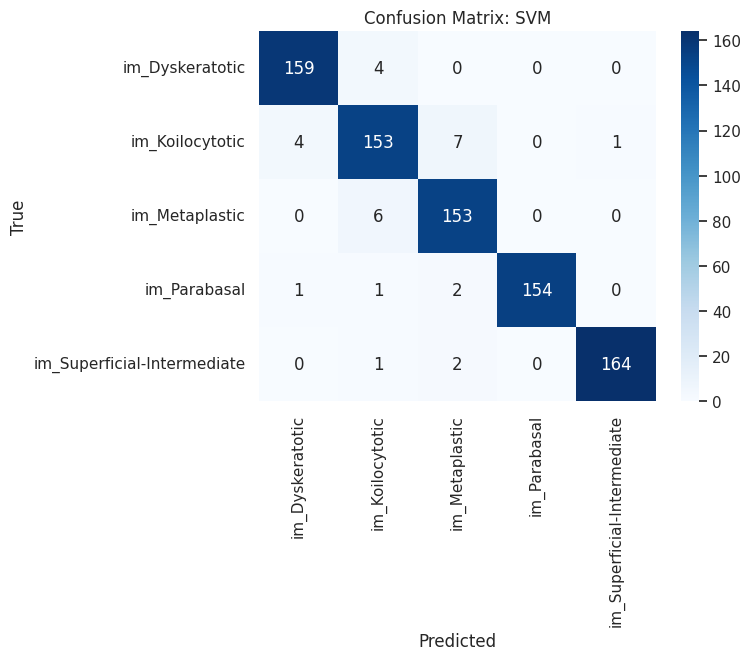


📊 XGBoost
Accuracy:       0.9569
Precision:      0.9571
Recall:         0.9568
F1-score:       0.9569
MCC:            0.9461
AUC-ROC:        0.9965
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       163
           1       0.91      0.92      0.91       165
           2       0.94      0.94      0.94       159
           3       0.99      0.97      0.98       158
           4       0.99      0.99      0.99       167

    accuracy                           0.96       812
   macro avg       0.96      0.96      0.96       812
weighted avg       0.96      0.96      0.96       812



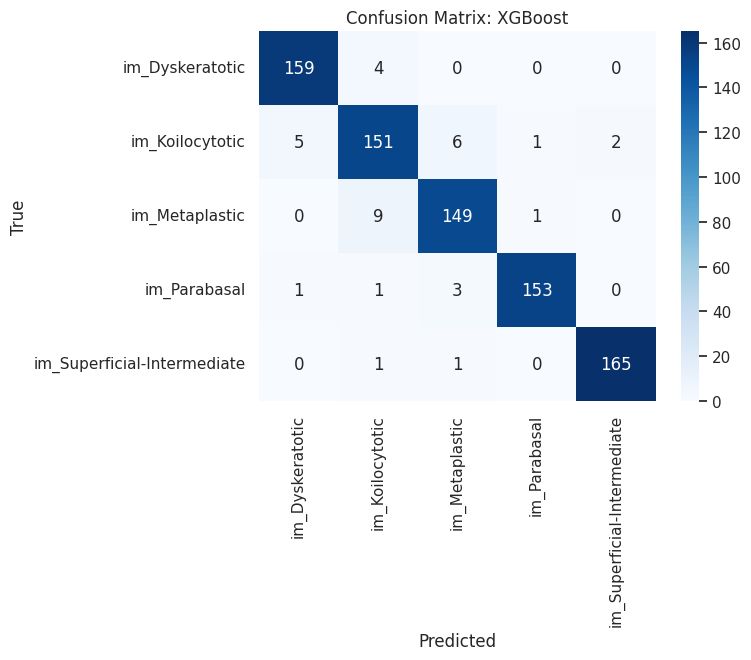

In [37]:
# K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(X_train_full, y_train_full)
evaluate_model(knn, X_test, y_test_lbl, "K-Nearest Neighbors")

# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_full, y_train_full)
evaluate_model(dt, X_test, y_test_lbl, "Decision Tree")

# Decision Tree
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_full, y_train_full)
evaluate_model(rf, X_test, y_test_lbl, "Random Forest")

# SVM
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train_full, y_train_full)
evaluate_model(svm, X_test, y_test_lbl, "SVM")

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train_full, y_train_full)
evaluate_model(xgb, X_test, y_test_lbl, "XGBoost")

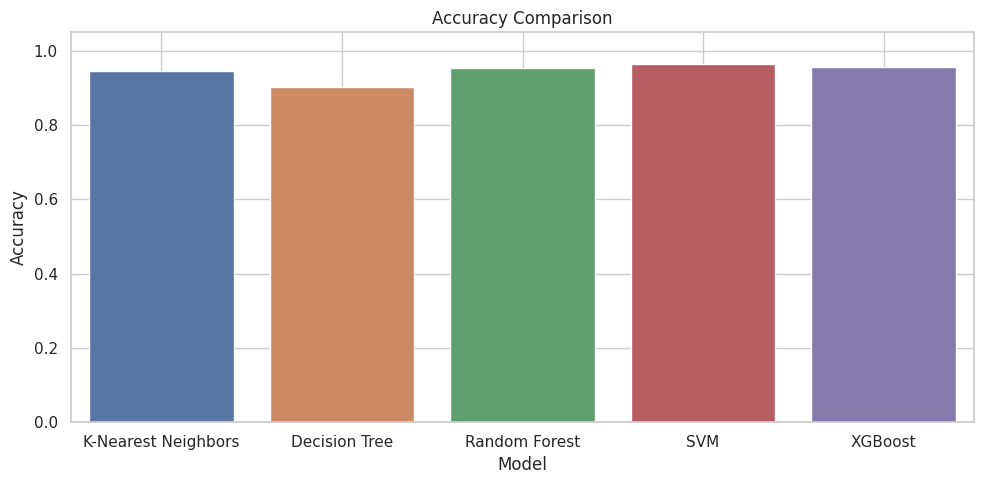

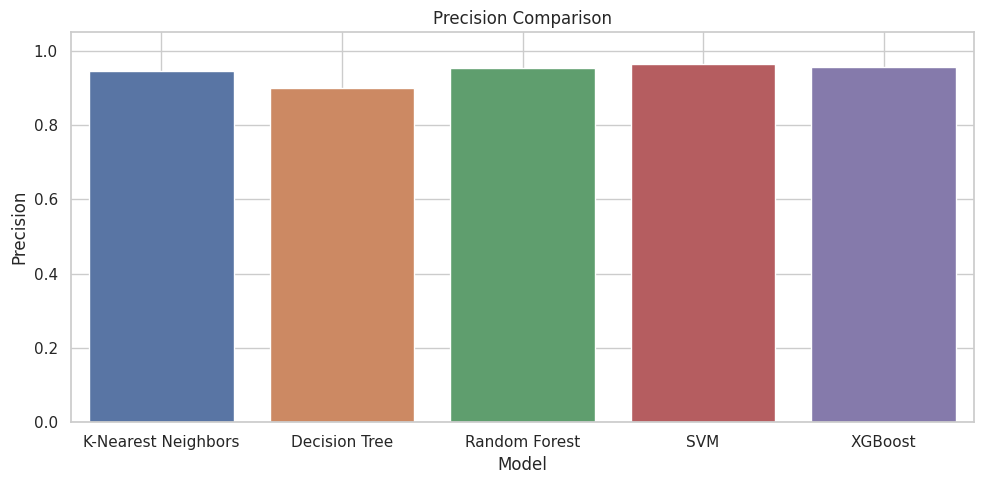

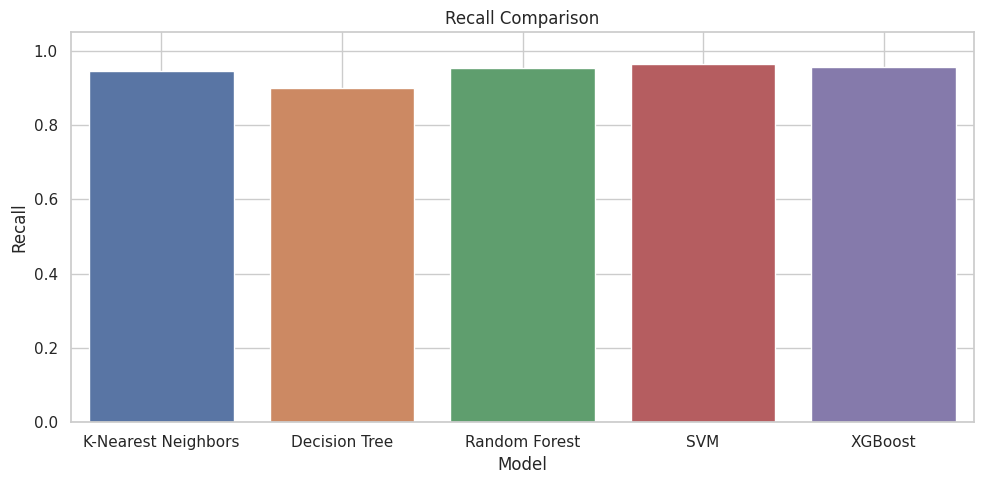

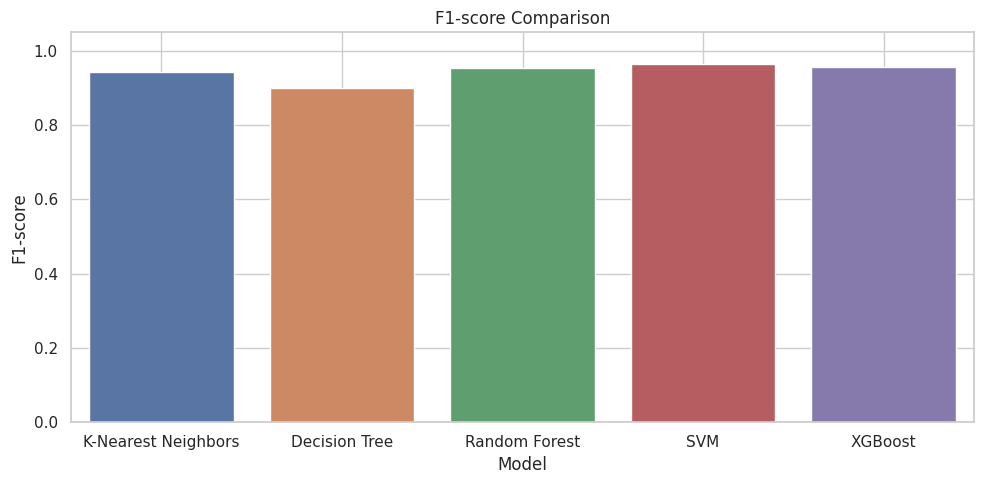

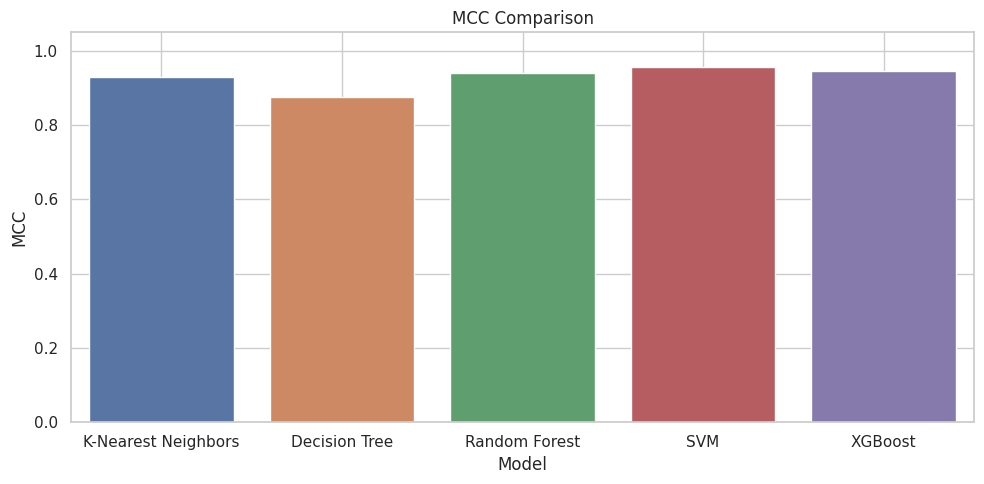

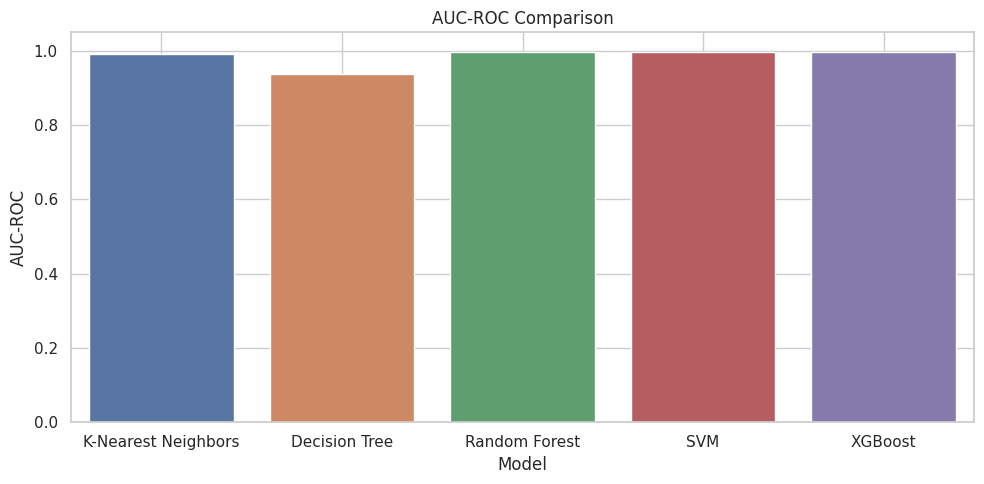

 Results saved to ml_model_scores.csv


In [41]:
# Plot evaluation results
df_scores = pd.DataFrame(model_scores)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'MCC', 'AUC-ROC']

for metric in metrics:
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Model', y=metric, data=df_scores)
    plt.title(f'{metric} Comparison')
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Save CSV
df_scores.to_csv("ml_model_scores.csv", index=False)
print(" Results saved to ml_model_scores.csv")